## Demand forecasting using historical sales

In this notebook I explore times series forecasting methods and models for forecasting product demand.<br>
Anticipating demand for products is a key requirement of any successful supply chain. Having an accurate estimate of demand can help an organization plan and control its supply chain to keep the customers happy with a certain degree of reliability of performance. Unanticipated changes in demand can cause stress on the supply chain eventually leading to customer dissatisfaction and eventually churn.<br>
We will explore two different ways to forecast:
1. Time series analysis of the sales data - Studying the data with respect to itself over time. 
 - ETS model
 - ARIMA models
2. Supervised learning - Use date time as features along with features derived from historical values of the data.
 - Linear Regression
 - LightGBM model

The data used is obtained from https://www.kaggle.com/c/demand-forecasting-kernels-only/data which provides the sales data for brick and mortar stores.<br>
Time series analysis will be used to forecast total monthly sales for the next 12 months.<br>
Supervised learning will be used to predict sales for a particular item for each day over the span of 1 year.

In [1]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
from scipy import stats
import warnings
from datetime import datetime
%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

### 1. Data Wrangling

Importing the data and checking for consistency

In [2]:
sales = pd.read_csv('Input/train.csv')

In [3]:
# Function to the dataframe consistency
def check_df(df):
    print('--------------------- Shape ---------------------')
    print(df.shape)
    print('--------------------- Head ---------------------')
    print(df.head())
    print('--------------------- Tail ---------------------')
    print(df.tail())
    print('--------------------- Info ---------------------')
    print(df.info())
    print('--------------------- Nulls ---------------------')
    print(df.isnull().sum(axis=0))
    print('------------------ Descriptive ------------------')
    print(df.describe())
    print('----------------- Unique Count -----------------')
    print(df.nunique())

check_df(sales)  

--------------------- Shape ---------------------
(913000, 4)
--------------------- Head ---------------------
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
--------------------- Tail ---------------------
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82
--------------------- Info ---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None
--------------------- Nulls ---------------------
date     0
s

__Outlier detection__

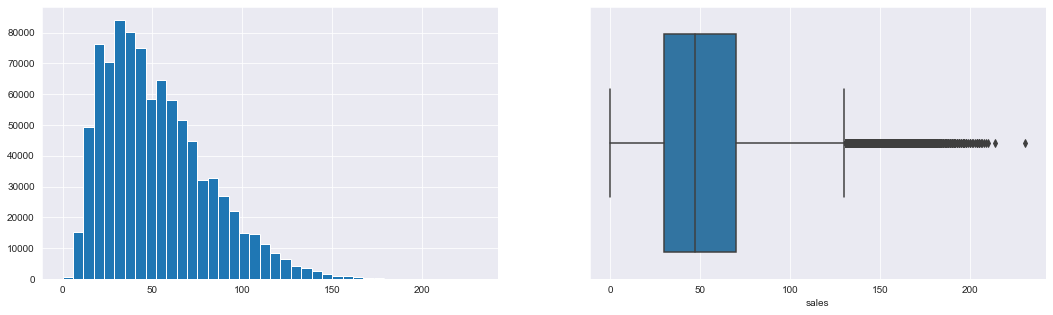

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
_ = ax1.hist(sales.sales, bins=40)
_ = sns.boxplot(sales.sales, ax=ax2)

We can see that we have a right skew. To assess the outliers better, we use a power transform on the data and check the z-scores against the normal distribution.

Percentage of outliers - z_Score >3 : 0.004


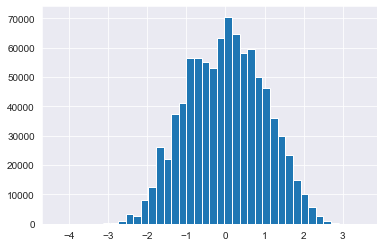

In [5]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
sales_trans = pt.fit_transform(sales[['sales']])
_ = plt.hist(sales_trans, bins=40)

print('Percentage of outliers - z_Score >3 :% .3f' % ((stats.zscore(sales_trans)>3).sum()*100/len(sales_trans)))

Consisitent with a normal distribution we only see 0.004% of the data outside 3 standard distributions and none beyond 3.5 standard distributions. We consider no outliers in this data and move on.

### 2. EDA

Lets check out the sales by items to see which ones are most dominant

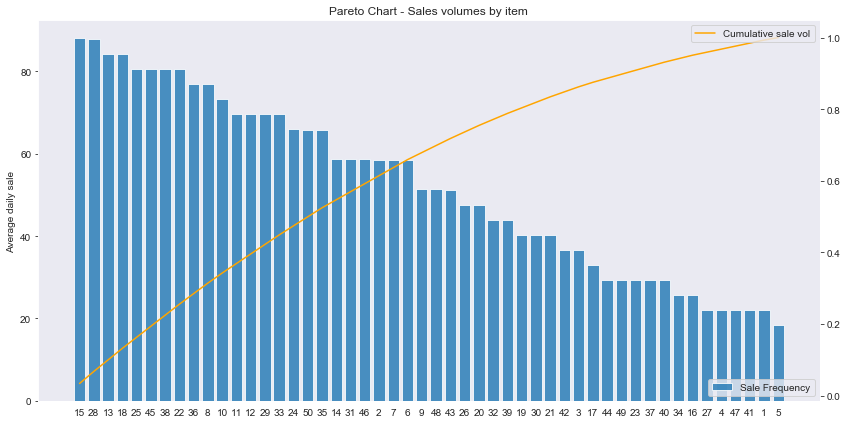

In [6]:
sales_by_item = sales.groupby('item')[['sales']].mean()
sales_by_item = sales_by_item.sort_values(by='sales', ascending=False).reset_index()
sales_by_item['cdf']=sales_by_item['sales'].cumsum()
sales_by_item['cdf']=sales_by_item['cdf']/sales_by_item['sales'].sum()

fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()
ax1.bar(sales_by_item.index, sales_by_item.sales, alpha=0.8, label='Sale Frequency')
ax2.plot(sales_by_item.index,  sales_by_item.cdf, c='orange', label='Cumulative sale vol')
ax1.set(xticks=sales_by_item.index , xticklabels=sales_by_item.item, title='Pareto Chart - Sales volumes by item',
        ylabel='Average daily sale')
ax1.grid(False)
ax2.grid(False)
ax1.legend(loc='lower right')
_ = ax2.legend(loc='upper right')

We see that we can cover about 80 percent of the sales volume by addressing the 1st 60% of the items (around 30 in number).

Lets look at data aggregation through different categories.

In [7]:
sales.groupby(['store', 'item']).agg({'sales':['sum', 'mean', 'median', 'std']})

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [8]:
# Converting date to datetime
sales['date'] = pd.to_datetime(sales['date'], format="%Y-%m-%d")

# Aggregating to total sales quantities (regardless of the item number) over date, month and week
sales_by_date = sales.groupby('date').sum()[['sales']]
sales_by_month = sales_by_date.resample('MS').mean()
sales_by_week = sales_by_date.resample('W').mean()

In [9]:
fig = px.line(sales_by_date, x=sales_by_date.index, y='sales', title='sales plot')
fig.update_xaxes(rangeslider_visible = True)

If we zoom in on the data, we can observe weekly sales patterns.<br>
And on the larger scale, we can observe monthly patterns in the data.<br>
We can determine from the plot that the data is seasonal and has a a strong trend (drift) associated with it.<br>
We can observe the monthly seasonality better with the plot below.

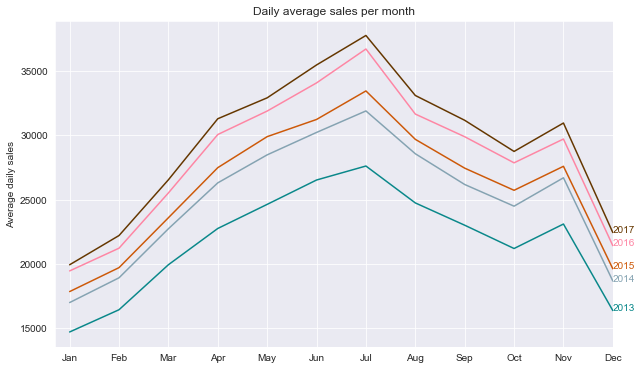

In [10]:
# Adding month and sales columns for plot
sales_by_month['month'] = sales_by_month.index.strftime('%b')
sales_by_month['year'] = sales_by_month.index.strftime('%Y')

years = sales_by_month['year'].unique()
np.random.seed(6)
my_colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
fig, ax = plt.subplots(figsize=(10, 6))
for i, y in enumerate(years):
    df = sales_by_month[sales_by_month['year']==y]
    ax.plot('month', 'sales', data=df, label=y, color=my_colors[i])
    ax.annotate(y, (df.iloc[-1]['month'], df.iloc[-1]['sales']), color=my_colors[i])
ax.set(xlim=(-0.3, 11), title='Daily average sales per month', ylabel='Average daily sales')
plt.show()

Next we look at the variation in sales through the years and through the months.

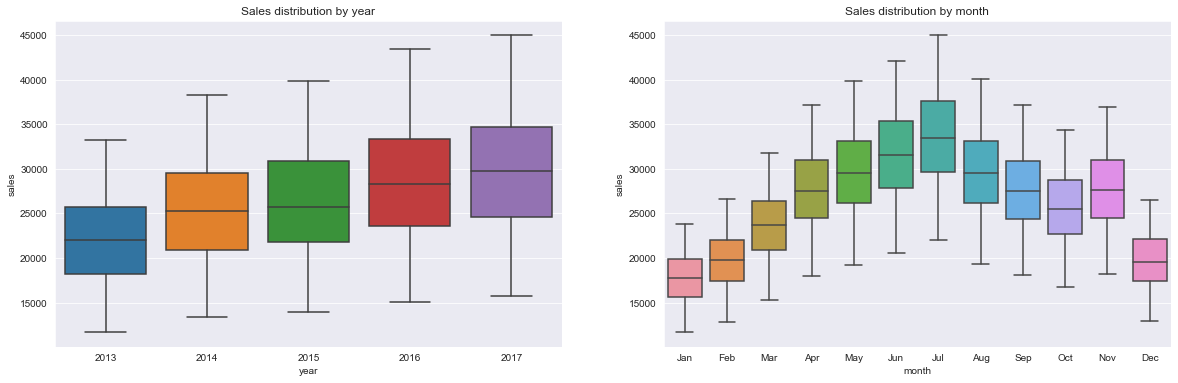

In [11]:
# Adding month and year columns for boxplot
sales_by_date['month'] = sales_by_date.index.strftime('%b')
sales_by_date['year'] = sales_by_date.index.strftime('%Y')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(x='year', y='sales', data=sales_by_date, ax=ax1)
sns.boxplot(x='month', y='sales', data=sales_by_date, ax=ax2)
ax1.set(title='Sales distribution by year')
ax2.set(title='Sales distribution by month')
plt.show()

We can see that the spread (variance) increases through the years and also across the months. Lets do a formal test to check for the 'stationarity' of the time series

### 3. Time Series Stationarity

It is evident looking at the series plot that it is not stationary. It contains both a trend and seasonality. In order to quanititatively test the stationarity of a time series, we use unit root tests namely, Augmented Dicky Fuller(ADF) test and KPSS test.<br>

__ADF test:__<br>
$H_{0}$ : The null hypothesis of ADF test is that a unit root is present and that the series __is not__ stationary.<br>

__KPSS test:__<br>
$H_{0}$ : Unit root does not exist and the series __is__ stationary.<br>

We check the p-values and test-statistic for each of the tests to check the stationarity:

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
sta_res1 = adfuller(sales_by_month['sales'].values, maxlag=12)
sta_res2 = kpss(sales_by_month['sales'].values, nlags='legacy')

if sta_res1[1] > 0.05:
    print('ADF test: Series is not stationary. P-value = %s' % sta_res1[1])
else :
    print('ADF test: Series is stationary. P-value = %s' % sta_res1[1])
    
if sta_res2[1] < 0.05:
    print('KPSS test: Series is not stationary. Failed to reject the null hypothesis. P-value = %s' % sta_res2[1])
else :
    print('KPSS test: Series is stationary. Null hypothesis rejected. P-value = %s' % sta_res2[1])

ADF test: Series is not stationary. P-value = 0.4830411796812205
KPSS test: Series is not stationary. Failed to reject the null hypothesis. P-value = 0.020106913659225525


Clearly the time series is not stationary.

### 4. Time series decomposition

A time series can be thought of as a combination of the level, trend, seasonality and the error term.<br>
Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:<br>

- Additive time series:<br>
> Value = Base Level + Trend + Seasonality + Error<br>

Used when the variance is more or less constant

- Multiplicative Time Series:<br>
> Value = Base Level x Trend x Seasonality x Error <br>

Used when we see a trend in the variance also, for example, an increasing variance in seasonality with increasing levels.<br>

Here we use the STL (Seasonal and Trend decomposition using Loess) method to decompose the series. STL is advantageous as it is capable of handling all periods of seasonality as well as allows for it to change over time aswell. The smoothness of the trend-cycle can be adjusted and the decomposition can also be made robust to outliers.

From here on out, we will be working with the averaged monthly sales over all items & stores.
The goal will be to try and forecast the total monthly sales for the organization.

In [14]:
# Importing STL from statsmodels tsa module
from statsmodels.tsa.seasonal import STL

#### 4.1 Additive Decomposition

In [15]:
# The dataset
sales = sales_by_month['sales']

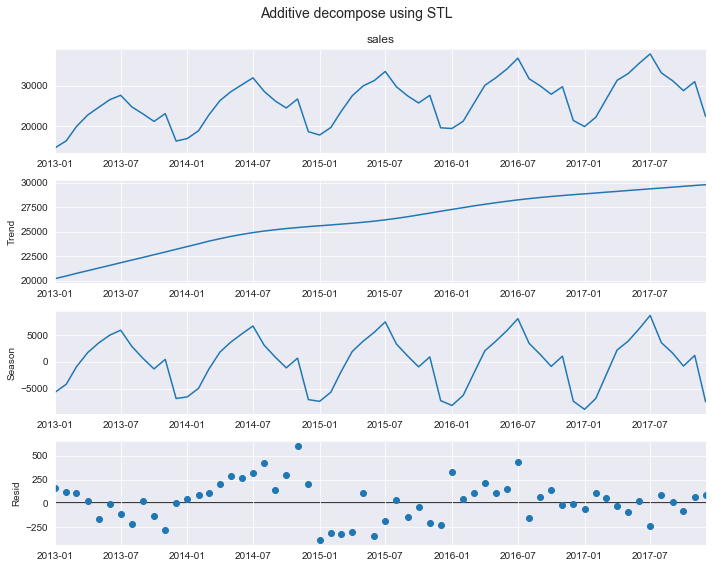

In [16]:
# Additive STL applied to the avg monthly sales
stl_add = STL(sales, period=12).fit()

plt.rcParams['figure.figsize']=(10, 8)
stl_add.plot()
plt.suptitle('Additive decompose using STL', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We can see a pattern in the residuals, indicating that the decomposition is leaving out information in the data.<br>
Lets try the multiplicative decomposition using STL. To acheive this, we simply take the natural log of the obsevations and then back transform to get the trend, season and residual components.

#### 4.2 Multiplicative Decomposition

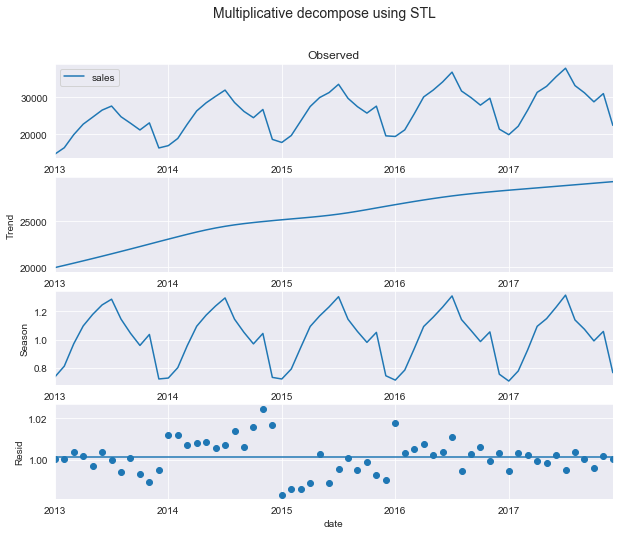

In [17]:
# Multiplicative STL applied to the log avg monthly sales
stl_mul = STL(np.log(sales), period=12).fit()

# The STL decomposition when back transformed will provide the multiplicative components.
stl_mul_T = np.exp(stl_mul.trend)
stl_mul_S = np.exp(stl_mul.seasonal)
stl_mul_E = np.exp(stl_mul.resid)

# Plotting the multiplicative decomposition
fig, ax = plt.subplots(4, 1, figsize=(10, 8))
sales_by_month[['sales']].plot(ax=ax[0], title='Observed')
stl_mul_T.plot(ax=ax[1])
stl_mul_S.plot(ax=ax[2])
stl_mul_E.plot(ax=ax[3], lw=0, style='o')
ax[3].axhline(stl_mul_E.mean())
ax[1].set(ylabel='Trend')
ax[2].set(ylabel='Season')
ax[3].set(ylabel='Resid')
plt.suptitle('Multiplicative decompose using STL', fontsize=14)
plt.show()

Again we see that the residuals donot look free from patterns.<br>

The characteristics of any good model would be that the errors or residuals are independent and uncorrelated. This means that we captured all the information possible from the model and left no processes behind in the error terms. Along with this we also look for normality of residuals with mean=0 for additive decompose and mean=1 for multiplicative decompose.

We can look at the autocorrelation plots of the residuals, If they are small and within the limits of *white noise*, we can say that the correlation observed is due to random process.

#### 4.3. Statistical test for uncorrelated residuals

A formal way to test this is a ljung-box test. The ljung-box test compares a time series to white noise to test for underlying autocorrelation between the observations.<br>
$H_{0}$ : The observations are iid. There exists no correlation between observations of a time series. <br>
$H_{a}$ : The observations are not iid. There exists some correlation between the observations. <br>

In [18]:
# Ljung Box test for autocorrelation of a series
from statsmodels.stats.diagnostic import acorr_ljungbox
print('LB test results for additive STL :\n')
print(acorr_ljungbox(stl_add.resid, lags=[1, 3, 6], return_df=True))
print('LB test results for multiplicative STL :\n')
print(acorr_ljungbox(stl_mul.resid, lags=[1, 3, 6], return_df=True))

LB test results for additive STL :

     lb_stat  lb_pvalue
1  12.429181   0.000423
3  25.415747   0.000013
6  26.014972   0.000221
LB test results for multiplicative STL :

     lb_stat  lb_pvalue
1  12.123907   0.000498
3  15.957644   0.001157
6  16.210680   0.012667


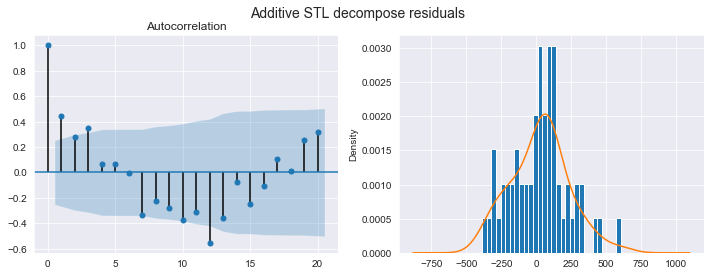

In [19]:
# Autocorrelation plots of Additive decompose
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(stl_add.resid, lags=20, ax=ax1)
stl_add.resid.plot(kind='hist', bins=30, density=True)
stl_add.resid.plot(kind='kde')
plt.suptitle('Additive STL decompose residuals', fontsize=14)
plt.show()

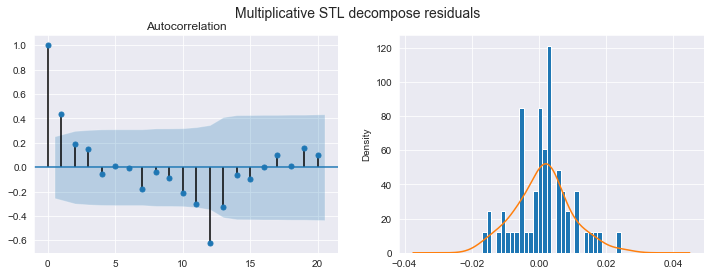

In [20]:
# Autocorrelation plots of multiplicative decompose
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(stl_mul.resid, lags=20, ax=ax1)
stl_mul.resid.plot(kind='hist', bins=30, density=True)
stl_mul.resid.plot(kind='kde')
plt.suptitle('Multiplicative STL decompose residuals', fontsize=14)
plt.show()

Looking at the p-values of the Ljung-Box test test and the autocorrelation plots of the residuals, we can say that autocorrelation in residuals is clearly present.

### Strength of the trend and seasonal components:
Though the STL decomposition did not adequately breakdown the time series, we can still check the strength of the trend and season from the components extracted from the decomposition.<br>
The strength of trend (Ft) and season (Fs) is calculated in comparison to the residual components by the following formula:
<div>
    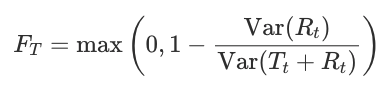
    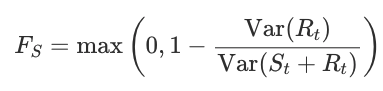
</div>
The smaller the residual compared to the trend and seasonal component, the stronger the strength of these components.

In [21]:
strength_trend = np.maximum(0, 1 - np.sum(np.var(stl_add.resid)/np.var(stl_add.trend+stl_add.resid)))
strength_season = np.maximum(0, 1 - np.sum(np.var(stl_add.resid)/np.var(stl_add.seasonal+stl_add.resid)))
print('Trend Strength of decomposition: %.3f' % strength_trend)
print('Seasonal Strength of decomposition: %.3f' % strength_season)

Trend Strength of decomposition: 0.995
Seasonal Strength of decomposition: 0.998


We observe a strong strength of both trend and season with values close to 1.

### 5. Time Series Point Forecast Methods
Next, we try forecasting using benchmark methods which produce point forecast but do not have the capability of preducing prediction intervals since they donot have any underlying statsitical model.

In [22]:
train = sales.loc[:'2016-12-01']
test = sales.loc['01-2017':]

#### 5.1 Benchmark Methods
Here we forecasts using simple benchmark methods to set our expectation right.

1. Avergage method - All future forecasts = Average value of all observations.
2. Naive method - All future forecasts = The last observation in the time series
3. Drift method - Prediction along a line connecting the 1st and the last observations
4. Seasonal Naive method - Future forecasts are set equal to seasonally lagged observations of a fixed seasonal period.

In [23]:
# Function for returning forecast performance of a method
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
def method_accuracy(model_name, true, fc):
    rmse = np.round(np.sqrt(mean_squared_error(true, fc)),3)
    mae = np.round(mean_absolute_error(true, fc), 3)
    mape = np.round(mean_absolute_percentage_error(true, fc), 3)
    scores = {'Model':model_name, 'RMSE':rmse, 'MAE':mae, 'MAPE':mape}
    return scores
# Dataframe to record method and model performance
model_scores = pd.DataFrame(columns=['Model', 'LB_pval', 'AICc', 'RMSE', 'MAE', 'MAPE', 
                                     'Max Interval Width', 'Mean Interval Width', 'Interval RMSE'])

In [24]:
# Forecasts from benchmark methods
avg_fc = [train.mean() for i in range(len(test.index))]
naive_fc = [train[-1] for i in range(len(test.index))] 
drift_fc = [train[-1] + (i)*(train[-1]-train[0])/(len(test.index)-1) for i in range(len(test.index))]
seasonal_naive_fc = [train[-12+i] for i in range(len(test.index))]
# Forecast method performance
model_scores = model_scores.append(method_accuracy('Average Method', avg_fc, test), ignore_index=True)
model_scores = model_scores.append(method_accuracy('Naive Method', naive_fc, test), ignore_index=True)
model_scores = model_scores.append(method_accuracy('Drift Method', drift_fc, test), ignore_index=True)
model_scores = model_scores.append(method_accuracy('Seasonal Naive Method', seasonal_naive_fc, test), 
                                   ignore_index=True)
model_scores

Model  LB_pval  AICc      RMSE       MAE   MAPE  \
0         Average Method      NaN   NaN  6729.500  5983.446  0.237   
1           Naive Method      NaN   NaN  9600.475  8227.185  0.384   
2           Drift Method      NaN   NaN  6923.365  5814.427  0.234   
3  Seasonal Naive Method      NaN   NaN  1119.109  1091.131  0.039   

   Max Interval Width  Mean Interval Width  Interval RMSE  
0                 NaN                  NaN            NaN  
1                 NaN                  NaN            NaN  
2                 NaN                  NaN            NaN  
3                 NaN                  NaN            NaN

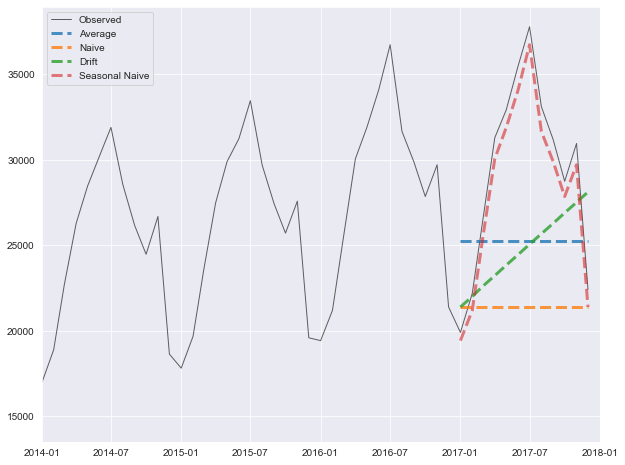

In [25]:
# Ploting forecasts from the benchmark methods
plt.plot(sales.index, sales, c='black', alpha=0.6, lw=1, label='Observed')
plt.plot(test.index, avg_fc, label='Average', lw=3, alpha=0.8, ls='dashed')
plt.plot(test.index, naive_fc, label='Naive', lw=3, alpha=0.8, ls='dashed')
plt.plot(test.index, drift_fc, label='Drift', lw=3, alpha=0.8, ls='dashed')
plt.plot(test.index, seasonal_naive_fc, label='Seasonal Naive', lw=3, alpha=0.6, ls='dashed')
plt.rcParams['figure.figsize']=(15, 6)
plt.xlim('2014','2018')
_ = plt.legend()

The seasonal naive method actually performs really well in this case. We observe a mean absolute percentage error of just 4% which is exceptionally good. This has to do with the fact that the sales in year 2016 and year 2017 are near identical.

#### 5.2 Holt-Winters' Exponential smoothing method
Next we see forecasts from the Holt-Winters' exponential smoothing method with uses exponential smoothing on the unobserved states of level, trend and seasonal components to forecast future values.<br>
Exponential smoothing can be additive or multiplicative in nature. Holt-Winter's method is the most general form of the exponential smoothing method and the fitted values/predictions are governed by the following equations:<br>
The following equations show how each of the components (level, trend and seasonality) are actually weighted averages of the components of the previous observation and the forecast of the components of the previous observation.<br><br>
<div>
    <b>Additive:</b>
    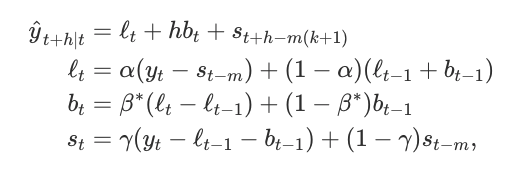
    <b>Multiplicative:</b>
    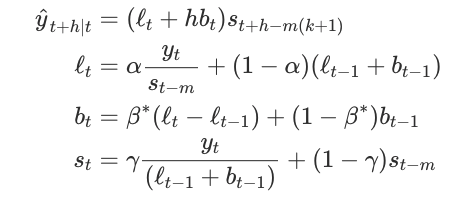
</div>
The initial states and level, trend and season coefficients are chosen so as to minimize the sum of square errors of the fitted values. 

In [26]:
# Building the Holt-Winters' model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
HW_add = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12,
                             initialization_method='heuristic').fit()
HW_mul = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12,
                             initialization_method='heuristic').fit()
# Holt-Winters' forecasts
hw_add_fc = HW_add.forecast(12)
hw_mul_fc = HW_add.forecast(12)

In [27]:
# Recording method performance
hw_add_scores = method_accuracy('HW Additive Method', hw_add_fc, test)
hw_add_scores.update({'AICc':round(HW_add.aicc, 3)})
hw_mul_scores = method_accuracy('HW Multiplicative Method', hw_mul_fc, test)
hw_mul_scores.update({'AICc':round(HW_mul.aicc, 3)})
model_scores = model_scores.append(hw_add_scores, ignore_index=True)
model_scores = model_scores.append(hw_mul_scores, ignore_index=True)
model_scores

Model  LB_pval     AICc      RMSE       MAE   MAPE  \
0            Average Method      NaN      NaN  6729.500  5983.446  0.237   
1              Naive Method      NaN      NaN  9600.475  8227.185  0.384   
2              Drift Method      NaN      NaN  6923.365  5814.427  0.234   
3     Seasonal Naive Method      NaN      NaN  1119.109  1091.131  0.039   
4        HW Additive Method      NaN  648.033   748.200   608.282  0.023   
5  HW Multiplicative Method      NaN  617.373   748.200   608.282  0.023   

   Max Interval Width  Mean Interval Width  Interval RMSE  
0                 NaN                  NaN            NaN  
1                 NaN                  NaN            NaN  
2                 NaN                  NaN            NaN  
3                 NaN                  NaN            NaN  
4                 NaN                  NaN            NaN  
5                 NaN                  NaN            NaN

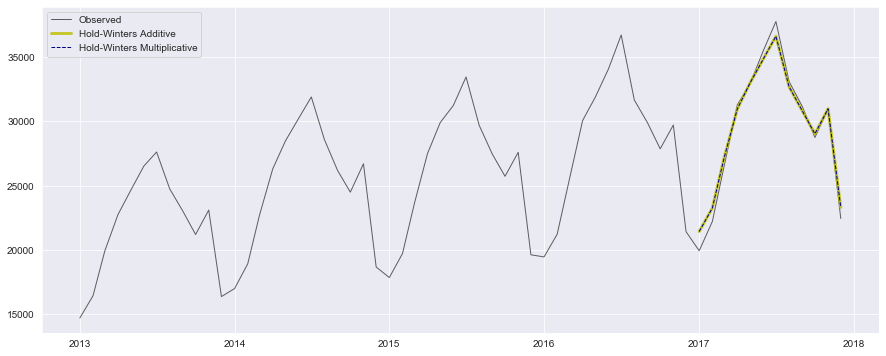

In [28]:
# Plotting the HW forecasts
plt.plot(sales.index, sales, c='black', alpha=0.6, lw=1, label='Observed')
plt.plot(test.index, hw_add_fc, label='Hold-Winters Additive', lw=3, alpha=0.8, c='y')
plt.plot(test.index, hw_add_fc, label='Hold-Winters Multiplicative', lw=1, alpha=1, ls='dashed', c='navy')
plt.legend()
plt.show()

Both Holt Winters' additive and multiplicative methods give identical forecasts and the test performance is better than seasonal naive with a MAPE of 2.3%. Although the multiplicative model fits the training data better with a lower AICc score.<br>

Methods can only provide point forecasts since they dont have an underlying statistical model that can take into account the uncertainty of sampling. Hence they are not much help when providing forecasts.<br>

### Statistical Models for time series forecasting:

Next we turn our attention to forecasting models. We particularly look two important classes of models:
- ETS models
- ARIMA models

__Note on the performance metrics of time series models:__<br>
In order to evaluate our model performance, we use the metrics suggested in *Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos* (https://otexts.com/fpp2/accuracy.html). This text only describes ways to assess the model's point forecasts compared to the actual values but does not provide a method to assess the prediction intervals produced by statistical models for forecasting.<br>
In order to assess the prediction intervals (on the basis of width of interval and location of the actual values within the interval), I use the sum of squared errors of the actual observations from the upper and lower intervals defined by the model. This metric will increase with increasing width of the interval, provided the location of the observed data is held constant within (or outside) of the prediction interval; and will also increase as the observations shift from the center of the interval (minimum if the observations lie at the center of the predicted interval). Thus it will provide a good measure to compare the narrowness and accuracy of prediction intervals from statistical time series model considered in this case.


Lets define the functions to assess our models

In [29]:
from statsmodels.graphics.gofplots import qqplot

# Function for plotting the residual diagnostics for ETS models
def plot_resid_diag(resid):
    std_resid = (resid-np.mean(resid))/np.std(resid)
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    ax[0, 0].plot(std_resid)
    ax[0, 0].axhline(std_resid.mean())
    std_resid.plot(kind='hist', density=True, bins=20, ax=ax[0,1], alpha=0.8)
    std_resid.plot(kind='kde', ax=ax[0,1], lw=1.5)
    qqplot(std_resid, line='q', ax=ax[1, 0])
    plot_acf(std_resid, lags=12, ax=ax[1,1])

    ax[0,0].set(title='Standardized residuals')
    ax[0,1].set(title='Histogram')
    ax[1,0].set(title='qq-plot')
    ax[1,1].set(title='correlogram')
    plt.suptitle('Residual diagnostics', fontsize=14)
    plt.show()
    
# Function for estimating model accuracy
def model_accuracy(model_name, model_fit, true, fc, pi_upr, pi_lwr):
    # Uncorrelated residual check
    LB_pval = round(acorr_ljungbox(model_fit.resid, lags=12)[1].min(), 2)
    # Model fit
    AICc  = np.round(model_fit.aicc, 3)
    # Model prediction accuracy
    rmse = np.round(np.sqrt(mean_squared_error(true, fc)),3)
    mae = np.round(mean_absolute_error(true, fc), 3)
    mape = np.round(mean_absolute_percentage_error(true, fc), 3)
    # Interval performance metrics
    int_max = np.round((pi_upr - pi_lwr).max(), 3)
    int_mean = np.round((pi_upr - pi_lwr).mean(), 3)
    int_rmse = np.round(np.sqrt(((pi_upr - true)**2 + (pi_lwr - true)**2).sum()), 3)
    scores = {'Model':model_name, 'LB_pval':LB_pval, 'AICc':AICc, 'RMSE':rmse, 'MAE':mae, 'MAPE':mape, 
              'Max Interval Width':int_max, 'Mean Interval Width':int_mean, 'Interval RMSE': int_rmse}
    return scores

# Function for plotting forecasts
def plot_forecasts(model_name, original, fitted, forecast, pi_upr, pi_lwr):
    plt.plot(original, label='Original', color='navy')
    fitted.plot(color='grey', label='Fitted', lw=3, alpha=0.6)
    forecast.plot(color='g', label='Point Forecast', lw=3, alpha=0.8)
    plt.fill_between(forecast.index, pi_upr, pi_lwr, color='mediumslateblue', alpha=0.3, 
                     label='Prediction Interval')
    plt.legend(loc='upper left')
    _ = plt.suptitle(f'{model_name} forecast', fontsize=18)


### 6. ETS model forecasting
ETS models (short for Error, Trend, Seasonal) have evolved out of the generalized state equations of the unobserved states of level, trend and seasonality in a time series. But unlike the Holt-Winters' method, they also take into account the distribution of the errors terms between the fitted and actual values.
The Holt-Winters' state equations can be re-expressed in the terms of the previous step forecast and an error term.
<div>
    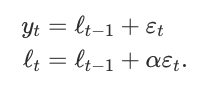
    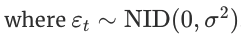
</div>
<br>
Only the level term is shown here with an additive error type. Similar equations can be obtained for the trend and seasonal components. These three components along with the error terms can be in multiple combinations of multiplicative and additive forms (as long as they are stable).<br>
The errors are assumed to be coming from a 'single' source and are assumed to be Normal and Independent.<br>

Next we try multiple configurations of the ETS method and get prediction forecasts for our sales data.

In [30]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import itertools

In [31]:
# Preparing ETS configurations
configs = list(itertools.product(('add', 'mul'), ('add', 'mul'), ('add', 'mul')))
model_names = ['ETS(AAA)', 'ETS(AAM)', 'ETS(AMA)', 'ETS(AMM)', 'ETS(MAA)', 'ETS(MAM)', 'ETS(MMA)', 'ETS(MMM)']
ets_models = dict(zip(model_names, configs))

# Dataframe for comparing ETS models
ets_scores = pd.DataFrame(columns=['Model', 'LB_pval', 'AICc', 'RMSE', 'MAE', 'MAPE', 
                                   'Max Interval Width', 'Mean Interval Width', 'Interval RMSE'])

# Selecting the best ETS model
for model_name, config in ets_models.items():
    model_fit = ETSModel(train, error=config[0], trend=config[1], seasonal=config[2], seasonal_periods=12,
                    initialization_method='heuristic').fit()
    fc_int = model_fit.get_prediction(start='01-2017', end='12-2017').summary_frame()    
    scores = model_accuracy(model_name, model_fit, test, model_fit.forecast(12), 
                            fc_int['pi_upper'], fc_int['pi_lower'])
    ets_scores = ets_scores.append(scores, ignore_index=True)

ets_scores

Model  LB_pval     AICc      RMSE       MAE   MAPE  Max Interval Width  \
0  ETS(AAA)     0.10  846.745  1167.792  1123.817  0.042            7338.118   
1  ETS(AAM)     0.12  837.659   978.520   946.969  0.033            6837.298   
2  ETS(AMA)     0.10  848.184  1286.597  1250.650  0.046            7974.332   
3  ETS(AMM)     0.11  839.368  1111.075  1082.949  0.037            6703.343   
4  ETS(MAA)     0.12  866.891  1341.893  1312.381  0.048           11505.044   
5  ETS(MAM)     0.16  855.168  1181.508  1148.572  0.039           10396.746   
6  ETS(MMA)     0.15  869.738  1580.011  1556.617  0.057           11789.673   
7  ETS(MMM)     0.15  857.155  1314.444  1283.238  0.044           10851.836   

   Mean Interval Width  Interval RMSE  
0             6534.319      17036.137  
1             6000.024      15495.888  
2             6915.084      18179.974  
3             6174.876      16086.395  
4             9037.417      23403.952  
5             8216.830      21243.280  
6             9729.002      25478.812  
7             8573.978      22375.637

We can observe from the model performance dataframe that:
- All ETS configurations produce uncorrelated residuals with the Ljungbox p-value (LB_pval) >= 0.1
- Multiplicative error cofigurations lead to much wider prediction intervals.
- ETS(AAM) model gives the best performance with the best:
    - Train data fit (AICc = 837)
    - Test data fit (MAPE = 3.3%)
    - Narrowest intervals (Mean Interval Width = 6000)
    - Least prediction interval RMSE = 15495

Next we fit the ETS(AAM) model and take a look at the forecast

### ETS(A,A,M) model

Additive error and trend, Multiplicative seasonal

In [32]:
ETS_AAM = ETSModel(train, error='add',trend='add', seasonal='mul', seasonal_periods=12, 
                      initialization_method='heuristic').fit()
print(ETS_AAM.summary())

                                 ETS Results                                  
Dep. Variable:                  sales   No. Observations:                   48
Model:                       ETS(AAM)   Log Likelihood                -414.365
Date:                Tue, 31 Aug 2021   AIC                            836.729
Time:                        19:09:59   BIC                            844.214
Sample:                    01-01-2013   HQIC                           839.558
                         - 12-01-2016   Scale                      1843756.610
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.1426      0.040      3.558      0.000       0.064       0.221
smoothing_trend        0.0117      0.009      1.295      0.195      -0.006       0.029
smoothing_seasonal  

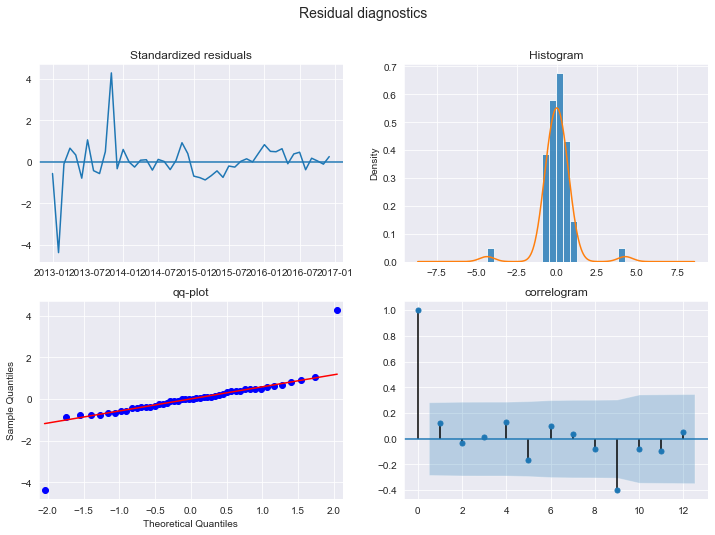

In [33]:
# Residual diagnostics of the ETS(A,A,M) model
plot_resid_diag(ETS_AAM.resid)

Residuals are well behaved. Only 2 spikes which are probably due to the initial state estimations. We fail to reject the null hypothesis for the Ljung-Box test (p-val=0.12) telling us that the residuals are uncorrelated and the model does not lack fit.<br>

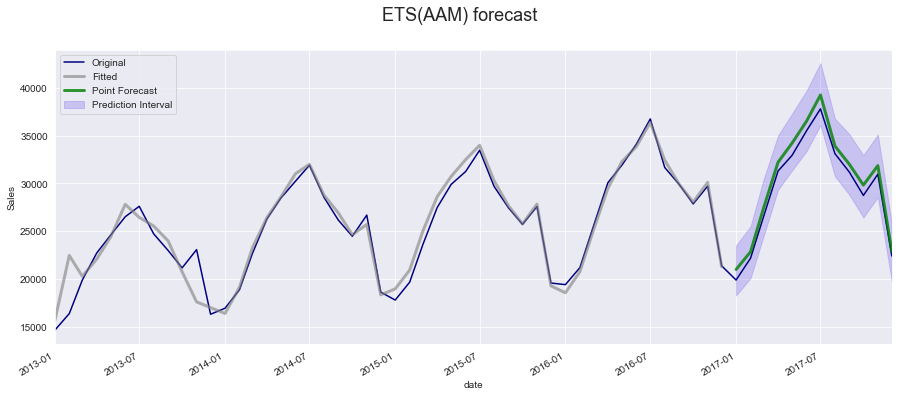

In [34]:
# Forecast Intervals
fc_int = ETS_AAM.get_prediction(start='01-2017', end='12-2017').summary_frame()
# Plot forecasts. Compare with the test set
plot_forecasts('ETS(AAM)', sales, ETS_AAM.predict(), ETS_AAM.forecast(12), 
               fc_int['pi_upper'], fc_int['pi_lower'])
_ = plt.ylabel('Sales')


In [35]:
# Append the model performance in our summary dataframe

scores = model_accuracy('ETS(A,A,M)', ETS_AAM, test, ETS_AAM.forecast(12), fc_int['pi_upper'], fc_int['pi_lower'])
model_scores = model_scores.append(scores, ignore_index=True)
model_scores

Model  LB_pval     AICc      RMSE       MAE   MAPE  \
0            Average Method      NaN      NaN  6729.500  5983.446  0.237   
1              Naive Method      NaN      NaN  9600.475  8227.185  0.384   
2              Drift Method      NaN      NaN  6923.365  5814.427  0.234   
3     Seasonal Naive Method      NaN      NaN  1119.109  1091.131  0.039   
4        HW Additive Method      NaN  648.033   748.200   608.282  0.023   
5  HW Multiplicative Method      NaN  617.373   748.200   608.282  0.023   
6                ETS(A,A,M)     0.12  837.659   978.520   946.969  0.033   

   Max Interval Width  Mean Interval Width  Interval RMSE  
0                 NaN                  NaN            NaN  
1                 NaN                  NaN            NaN  
2                 NaN                  NaN            NaN  
3                 NaN                  NaN            NaN  
4                 NaN                  NaN            NaN  
5                 NaN                  NaN            NaN  
6            6536.461             6026.561      15531.987

### 7. ARIMA model forecasting
ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is a class of models that ‘explains’ a given time series based on its own past values (lags) and the lagged forecast errors.<br>
ARIMA models are based on defining a 'stationary' series as a sum of Autoregressive component and a Moving Averages components. The integration step is the inverse of the differencing performed to make the time series stationary.<br>
For a seasonal and non-seasonal data, the number of differences required to make a series stationary can be determined by a unit root tests.
An autoregressive component of the model of an order *p* can be defined as:

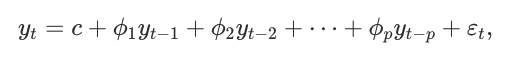

While the moving averages components of an order *q* can be defined as:
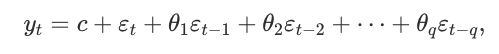

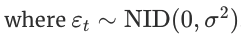

And,<br>
$y_{t-k}$ is the value of the observation at lag k <br>
$e_{t-k}$ is the value of the forecast error at lag k<br>


Once a time series is stationary, the above AR(p) and MA(q) terms can be used to define the stationary time series. When integrated back to the original order of the time series, provides the predictions/forecasts.<br> The Normal and independent error term provides the basis for calculating the prediction intervals.<br>

For a time series with seasonality, AR(P) and MA(Q) terms are added to the model for a seasonally differenced series with difference D.<br>
Hence a __seasonal ARIMA model__ can be described as:

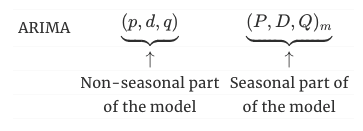

where m is the period of seasonality for the data.

__Note: ARIMA vs ETS models__<br>
Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the level, trend and seasonality in the data, ARIMA models aim to describe the time series through autocorrelations in the observations of the series.

#### Stationarize the time series: Determining the order of differencing<br>
The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.<br>
An intuitive way to think about this is in terms of differentiation:
- A series with a linear trend will need differencing once
- A series with a quadratic trend will need differencing twice
- A series with seasonality will need one seasonal difference.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced. If the ACF plot drops within the white noise limit fairly quickly (1-2 lags) then it is appropriately differenced.<br>
We check the stationarity through the KPSS test discussed earlier. We can also check the standard deviation of the differenced series for a comparison between difference types of differencing and choose the one with the least standard deviation.

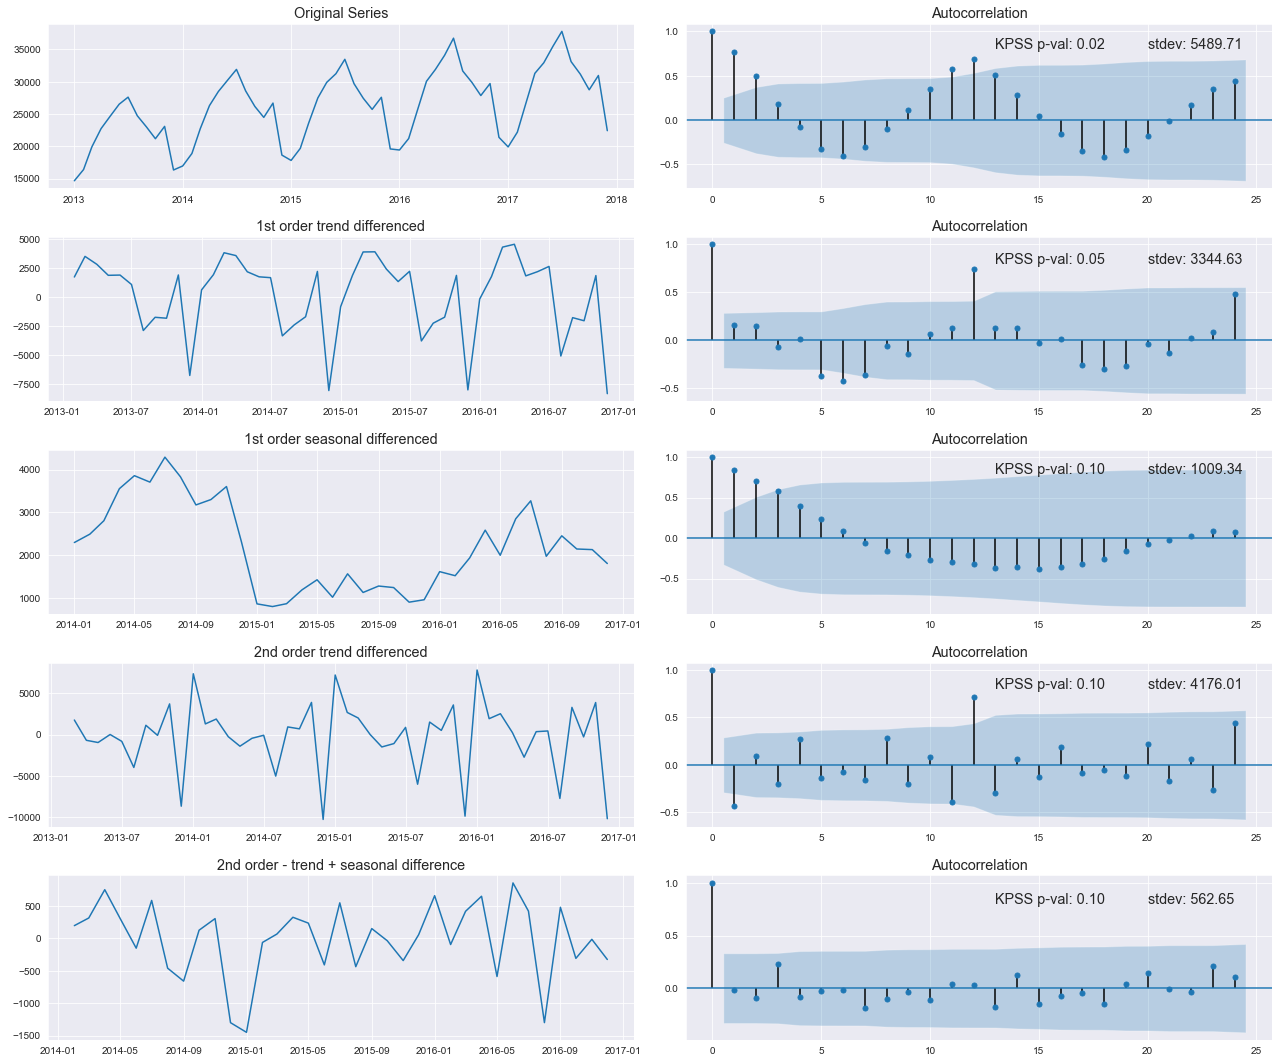

In [36]:
# Various differenced series
sales_diff = train.diff()[1:]              #Differenced once trend
sales_diff_s = train.diff(12)[12:]         #Differenced once seasonal
sales_diff2 = train.diff().diff()[2:]      #Differenced twice trend
sales_diff_st = train.diff(12).diff()[13:] #Difference once seasonal and once trend
series_list = [sales, sales_diff, sales_diff_s, sales_diff2, sales_diff_st]

# Plots
fig, ax = plt.subplots(5,2, figsize=(18, 15))
sns.set_context('notebook', font_scale=1.2)
for i, series in enumerate(series_list):
    kpss_pval = kpss(series, nlags=12)[1]          #KPSS test p-value
    stdev = np.std(series)                         #Standard deviation
    ax[i, 0].plot(series)                          #Series plot
    plot_acf(series, lags=24, ax=ax[i, 1])         #ACF plot
    #Annotations
    ax[i, 1].annotate('KPSS p-val: %.2f'%kpss_pval, (13, 0.8))
    ax[i, 1].annotate('stdev: %.2f'%stdev, (20, 0.8))
ax[0, 0].set_title('Original Series')
ax[1, 0].set_title('1st order trend differenced')
ax[2, 0].set_title('1st order seasonal differenced')
ax[3, 0].set_title('2nd order trend differenced')
ax[4, 0].set_title('2nd order - trend + seasonal difference')

plt.tight_layout()
plt.show()


The KPSS test p-values tell us that the original and the 1st order differenced series are not stationary. The ACF plots for 1st order seasonal difference and 2nd order trend differenced show anomalies. The 2nd order trend + seasonal difference looks like the best choice. Although, to keep things simple, we can also look at the 1st order seasonally differenced series.

__Determining the value of p, q, P & Q for the seasonal ARIMA model__<br>
We use partial autocorrelation (PACF) and autocorrelation (ACF) plots to determine the order of the AutoRegressive and Moving Averages components of the ARIMA model, respectively.<br>

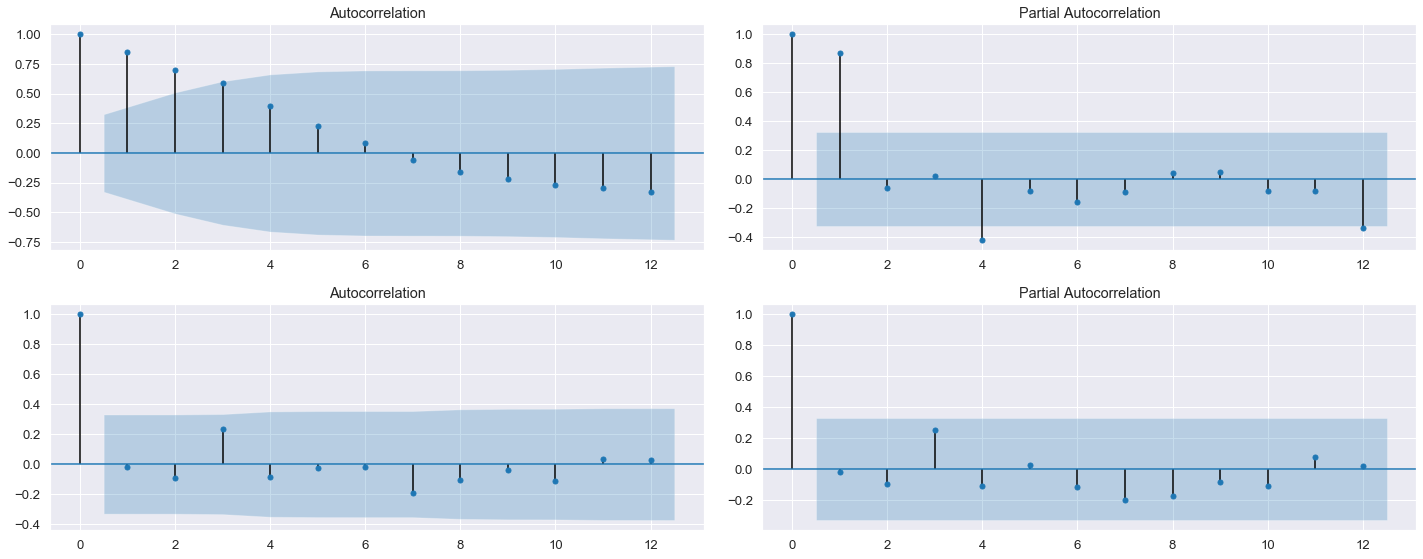

In [37]:
sales_diff = sales_by_month['sales'].diff(12)[12:]

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
plot_acf(sales_diff_s, lags=12, ax=ax[0, 0])
plot_pacf(sales_diff_s, lags=12, ax=ax[0, 1])

plot_acf(sales_diff_st, lags=12, ax=ax[1, 0])
plot_pacf(sales_diff_st, lags=12, ax=ax[1, 1])
plt.tight_layout()
plt.show()

For seasonally difference series of order (d) = 1 <br>
The exponentially decaying ACF and the significant spike in the PACF at lag 12 suggests a seasonal AR order (P) of 1.<br>
The significant spikes in the PACF at lags 1 and 2 suggest a non-seasonal AR order (p) of 2.

For seasonal + trend differenced series (d, D) = 1, <br>
The significant spikes in ACF and PACF at lag 1 suggest an MA(Q) and MA(q) order of 1.<br>

Since the above techniques of order selection are reliable only when one of p or q is equal to zero, we try different configurations of the seasonal ARIMA model and select the best one based on performance.

In [38]:
from statsmodels.tsa.arima.model import ARIMA

In [39]:
# Constructing parameter configurations
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
order = list(itertools.product(p, d, q))
seasonal_order = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
AIC_min = 10000
# Data frame for model comparison
arima_scores = pd.DataFrame(columns=['Model', 'LB_pval', 'AICc', 'RMSE', 'MAE', 'MAPE', 
                                   'Max Interval Width', 'Mean Interval Width', 'RMSE Interval'])
# Try all configurations and store performance results
for param in order:
    for param_seasonal in seasonal_order:
        try:
            if (param[1] + param_seasonal[1]) > 0:    # Ensures atleast a one order of differencing
                model = ARIMA(train, order=param, seasonal_order=param_seasonal)
                model_fit = model.fit()
                fc = model_fit.predict(start='01-2017', end='12-2017')
                fc_int = model_fit.get_forecast(12).conf_int(alpha=0.05)
                scores = model_accuracy(f'ARIMA{param}x{param_seasonal}12', model_fit, test, fc,
                                        fc_int['upper sales'], fc_int['lower sales'])
                arima_scores = arima_scores.append(scores, ignore_index=True)               
        except:
            continue

Shortlisting the models based on performance parameters

In [40]:
# Removing all models that fail the residual test
candidates = arima_scores[arima_scores['LB_pval'] > 0.05]
# Top ARIMA models based on performance
best_arima=pd.DataFrame()
for param in candidates.min().index[2:]:
    best_arima = best_arima.append(candidates[candidates[param]==candidates.min()[param]])
    
best_arima = best_arima.drop_duplicates()

The above three models show the best performance in terms fitting training data (AICc), point predictions vs test observations (RMSE, MAE, MAPE) and Interval performance (Max Interval Width, Mean Interval Width and RMSE Interval).<br>
The ARIMA(2, 1, 2)x(0, 1, 0, 12)12 model predicts the best point forecasts and has nearly the best interval performance so we go ahead with it and see the results.

### ARIMA(2, 1, 2)x(0, 1, 0, 12)12  model
(p, d, q) = (2, 1, 2)<br>
(P, D, Q, M) = (0, 1, 0, 12)

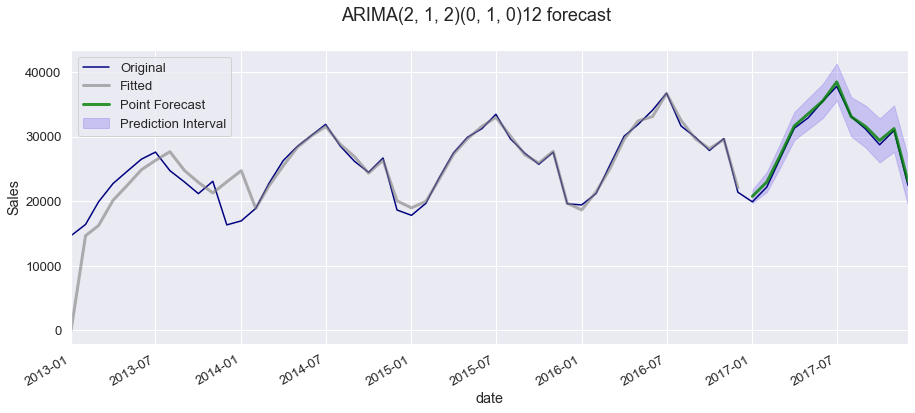

In [41]:
# Fit the best model
arima = ARIMA(train, order=(2, 1, 2), seasonal_order=(0, 1, 0, 12)).fit()
# Fitted values
pred = arima.predict(start='01-2013', end='12-2016')
# Forecast
fc = arima.predict(start='01-2017', end='12-2017')
# Prediction intervals
fc_int = arima.get_forecast(12).conf_int(alpha=0.05)
# Plot forecasts
plot_forecasts('ARIMA(2, 1, 2)(0, 1, 0)12', sales, pred, fc , fc_int['upper sales'], fc_int['lower sales'])
_ = plt.ylabel('Sales')

In [42]:
scores = model_accuracy('ARIMA(2, 1, 2)x(0, 1, 0, 12)12', arima, test, fc, 
                        fc_int['upper sales'], fc_int['lower sales'])

model_scores = model_scores.append(scores, ignore_index=True)
model_scores

Model  LB_pval     AICc      RMSE       MAE  \
0                  Average Method      NaN      NaN  6729.500  5983.446   
1                    Naive Method      NaN      NaN  9600.475  8227.185   
2                    Drift Method      NaN      NaN  6923.365  5814.427   
3           Seasonal Naive Method      NaN      NaN  1119.109  1091.131   
4              HW Additive Method      NaN  648.033   748.200   608.282   
5        HW Multiplicative Method      NaN  617.373   748.200   608.282   
6                      ETS(A,A,M)     0.12  837.659   978.520   946.969   
7  ARIMA(2, 1, 2)x(0, 1, 0, 12)12     0.06  550.040   544.555   477.686   

    MAPE  Max Interval Width  Mean Interval Width  Interval RMSE  
0  0.237                 NaN                  NaN            NaN  
1  0.384                 NaN                  NaN            NaN  
2  0.234                 NaN                  NaN            NaN  
3  0.039                 NaN                  NaN            NaN  
4  0.023                 NaN                  NaN            NaN  
5  0.023                 NaN                  NaN            NaN  
6  0.033            6536.461             6026.561      15531.987  
7  0.018            7474.588             5243.801      13715.913

ARIMA model with configuration (2, 1, 2)x(0, 1, 0, 12)12 emerges as the winner over all with best fit, point forecast performance and prediction interval performance.<br>

### 8. Time series as Supervised learning

Till now we explored the two most widely used models for time series analysis.<br> These models look for historical patterns in data w.r.t time and try to forecast a future value of the variable in question. 
The ETS model defines the time series on the basis of level, trend and seasonality components (which are estimated by fitting to the historical data) while the ARIMA model models the differenced series on the basis of lagged predictors and their forecast errors.

__Time series as supervised learning:__<br>
Because of the way regression models work, linearly increasing date-time information does not provide any predictive value, we need to disintegrate the date-time information into useful categorical features such as 'day of week', 'month of year' etc.Along with date-time features, we also add lagged predictors and moving averages for different periods as predictors to the model.<br>

Future forecasts are estimate based on the value of these features (ex. Monday, June, ema20 value etc) unlike a point in the time as is applicable for time-series models. Supervised models for time series may or may not offer methods to calculate prediction intervals.

In order to solve as a supervised learning, we pick the top selling item from the sales dataset and try to forecast its sales on a daily granularity.

We select Item No. 15 to predict sales.

In [43]:
# Select the top item (no 15) to forecast
sales = pd.read_csv('Input/train.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales15 = sales[sales['item']==15].groupby('date').sum()[['sales']]
sales15 = sales15.reset_index()
sales15.sort_values(by='date', inplace=True)

### Feature Engineering

We develop our features from the date-time information, lagged predictors and moving averages.

__Date related categorical features__

The following date features are added:
- Day of the week
- Day of the month
- Week of the year
- Month of the year
- Year
- Is a weekend or not

In [44]:
# Add date time features
sales15['day_of_week'] = sales15.date.dt.dayofweek
sales15['day_of_month'] = sales15.date.dt.day
sales15['week_of_year'] = sales15.date.dt.weekofyear
sales15['month'] = sales15.date.dt.month
sales15['year'] = sales15.date.dt.year
sales15["is_wknd"] = sales15.date.dt.weekday // 5
sales15.head()

date  sales  day_of_week  day_of_month  week_of_year  month  year  \
0 2013-01-01    453            1             1             1      1  2013   
1 2013-01-02    442            2             2             1      1  2013   
2 2013-01-03    487            3             3             1      1  2013   
3 2013-01-04    533            4             4             1      1  2013   
4 2013-01-05    604            5             5             1      1  2013   

   is_wknd  
0        0  
1        0  
2        0  
3        0  
4        1

Even in this form, the date features do not provide any value to the regression problem. This is because patterns are seen cyclically in time not as straight lines of increasing day, month and week numbers (days 30, 31 and 30, 1 have the same distance to each other = 1 day).<br>
To represent the date features in cyclic-numeric terms we take the sin of the values.

In [45]:
# Converting linear time to cyclical features
sales15[['month', 'day_of_month', 'week_of_year', 'day_of_week']] = \
    sales15[['month', 'day_of_month', 'week_of_year', 'day_of_week']].apply(lambda x: np.sin(x*3.14*2/x.nunique()))

Text(0, 0.5, 'sin transform')

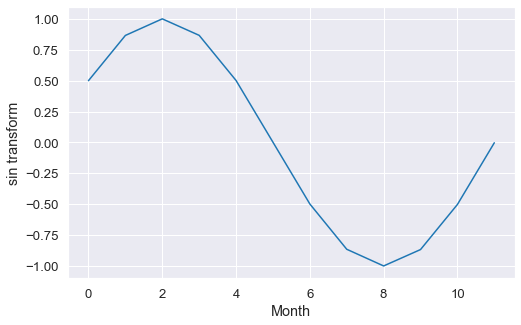

In [46]:
# Month would look like this:
plt.figure(figsize=(8, 5))
_ = plt.plot(np.arange(len(sales15['month'].unique())), sales15['month'].unique())
plt.xlabel('Month')
plt.ylabel('sin transform')

__Lagged predictors__

1st, 2nd and 3rd lag predictors are added to the model

In [47]:
# Function to create lagged predictors given a list of lags
def lag_features(dataframe, column, lags):
    df = dataframe.copy()
    for lag in lags:
        df['sales_lag_' + str(lag)] = df[column].shift(lag) + random_noise(df)
    return df

# Random noise generator for to avoid overfitting in lagged predictors
def random_noise(dataframe):
    return np.random.normal(size=(len(dataframe),))

In [48]:
# Adding lagged predictors
sales15 = lag_features(sales15, 'sales', [1, 2, 3])

__Moving Averages__

Expontially weighted moving averages are added as features for the following periods:
- 30 days
- 3 months
- 6 months
- 9 months
- 12 months

In [49]:
# Function to create SMAs given a different window lengths
def create_ma(dataframe, column, windows, min_periods=20):
    df = dataframe.copy()
    for window in windows:
        df['ma_' + str(window)] = df[column].shift(1).rolling(window=window, min_periods=min_periods).mean()
    return df

In [50]:
# Moving averages as level/trend predictors (1, 3, 6, 9 and 12 months)
sales15 = create_ma(sales15, 'sales', [30, 90, 181, 243, 365])

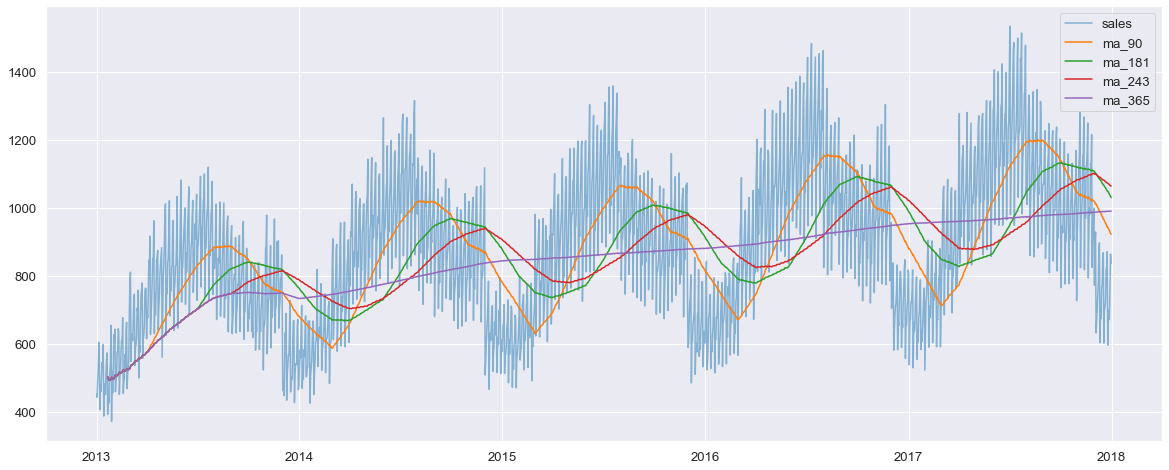

In [51]:
# Plot the moving averages
sns.set_context('notebook', font_scale=1.2)
plt.figure(figsize=(20, 8))
for col in ['sales', 'ma_90', 'ma_181', 'ma_243', 'ma_365']:
    plt.plot(sales15['date'], sales15[col], label=col, alpha=(0.5 if col=='sales' else 1))

_ = plt.legend()

__Exponentially Weighted Moving Averages__

Expontially weighted moving averages are added as features for the following periods:
- 20 days
- 50 days
- 100 days
- 200 days
- 300 days

In [52]:
# Function to create EMAs given a different span width
def create_ema(dataframe, column, spans, min_periods=20):
    df = dataframe.copy()
    for span in spans:
        df['ema_' + str(span)] = df[column].shift(1).ewm(span=span, min_periods=min_periods).mean()
    return df

In [53]:
# Add ema features
sales15 = create_ema(sales15, 'sales', [20, 50, 100, 200, 300])

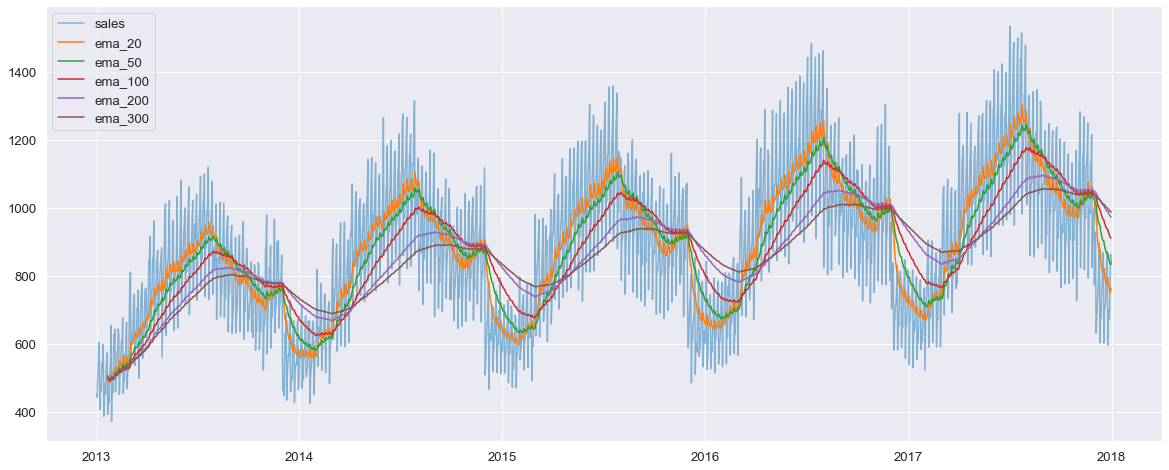

In [54]:
# Plot ema features
plt.figure(figsize=(20, 8))
for col in ['sales', 'ema_20', 'ema_50', 'ema_100', 'ema_200', 'ema_300']:
    plt.plot(sales15['date'], sales15[col], label=col, alpha=(0.5 if col=='sales' else 1))
plt.legend()

In [55]:
sales15.head()

date  sales  day_of_week  day_of_month  week_of_year    month  year  \
0 2013-01-01    453     0.781548      0.201198      0.118213  0.49977  2013   
1 2013-01-02    442     0.975130      0.394167      0.118213  0.49977  2013   
2 2013-01-03    487     0.435113      0.571015      0.118213  0.49977  2013   
3 2013-01-04    533    -0.432243      0.724510      0.118213  0.49977  2013   
4 2013-01-05    604    -0.974419      0.848372      0.118213  0.49977  2013   

   is_wknd  sales_lag_1  sales_lag_2  ...  ma_30  ma_90  ma_181  ma_243  \
0        0          NaN          NaN  ...    NaN    NaN     NaN     NaN   
1        0   453.838259          NaN  ...    NaN    NaN     NaN     NaN   
2        0   441.393583   452.701101  ...    NaN    NaN     NaN     NaN   
3        0   486.006140   441.015667  ...    NaN    NaN     NaN     NaN   
4        1   532.472620   486.031328  ...    NaN    NaN     NaN     NaN   

   ma_365  ema_20  ema_50  ema_100  ema_200  ema_300  
0     NaN     NaN     NaN      NaN      NaN      NaN  
1     NaN     NaN     NaN      NaN      NaN      NaN  
2     NaN     NaN     NaN      NaN      NaN      NaN  
3     NaN     NaN     NaN      NaN      NaN      NaN  
4     NaN     NaN     NaN      NaN      NaN      NaN  

[5 rows x 21 columns]

In [56]:
# First 20 rows contain NA's since the min moving average period was 20 observations. We remove these
sales15.dropna(inplace=True)

In [57]:
print('Nulls: ', sales15.isnull().any(axis=1).sum())
print('Shape: ', sales15.shape)

Nulls:  0
Shape:  (1806, 21)


__Split the data into train and test sets:__

In [58]:
train = sales15[sales15['date']<'2017-01-01']
test = sales15[sales15['date']>='2017-01-01']

xtrain = train.drop(columns=['date', 'sales'])
ytrain = train['sales']
xtest = test.drop(columns=['date', 'sales'])
ytest = test['sales']

### Machine learning on the dataset

### Linear Regression

In [59]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

Since a linear regression doesnt take multicollinearity well and since we are interested in feature importances, we look at a heatmap and remove multicollinearity

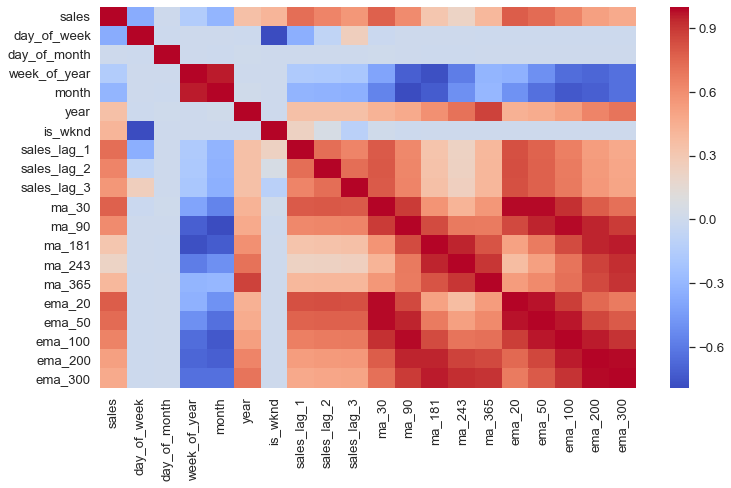

In [60]:
plt.figure(figsize=(12, 7))
sns.heatmap(train.corr(), cmap='coolwarm')

In [61]:
# Identifying correlated features
c = train.corr().abs().unstack()
c = c[c>0.9]
c = c.reset_index()
c = c[~(c['level_0'] == c['level_1'])]
c

level_0       level_1         0
4   week_of_year         month  0.958026
5          month  week_of_year  0.958026
13         ma_30        ema_20  0.989542
14         ma_30        ema_50  0.988209
15         ma_30       ema_100  0.918509
17         ma_90        ema_50  0.945660
18         ma_90       ema_100  0.992100
19         ma_90       ema_200  0.948293
21        ma_181        ma_243  0.946594
22        ma_181       ema_200  0.949532
23        ma_181       ema_300  0.959935
24        ma_243        ma_181  0.946594
26        ma_243        ma_365  0.902362
27        ma_243       ema_300  0.926673
28        ma_365        ma_243  0.902362
30        ma_365       ema_300  0.909328
31        ema_20         ma_30  0.989542
33        ema_20        ema_50  0.972248
34        ema_50         ma_30  0.988209
35        ema_50         ma_90  0.945660
36        ema_50        ema_20  0.972248
38        ema_50       ema_100  0.965036
39       ema_100         ma_30  0.918509
40       ema_100         ma_90  0.992100
41       ema_100        ema_50  0.965036
43       ema_100       ema_200  0.958318
44       ema_100       ema_300  0.910451
45       ema_200         ma_90  0.948293
46       ema_200        ma_181  0.949532
47       ema_200       ema_100  0.958318
49       ema_200       ema_300  0.989189
50       ema_300        ma_181  0.959935
51       ema_300        ma_243  0.926673
52       ema_300        ma_365  0.909328
53       ema_300       ema_100  0.910451
54       ema_300       ema_200  0.989189

Issue should be resolved on removing ema's and a ma_243

In [62]:
# Removing ema's and spacing the ma's to reduce correlation (Only for Linear Regression)
xtrain_LR = xtrain.drop(columns=['ema_20', 'ema_50', 'ema_100', 'ema_200', 'ema_300', 'ma_243'])

In [63]:
LR = OLS(ytrain, xtrain_LR).fit()
print(LR.summary())

                                 OLS Regression Results                                
Dep. Variable:                  sales   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.039e+04
Date:                Tue, 31 Aug 2021   Prob (F-statistic):                        0.00
Time:                        19:12:14   Log-Likelihood:                         -8532.2
No. Observations:                1441   AIC:                                  1.709e+04
Df Residuals:                    1428   BIC:                                  1.716e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Lets take a look at the residuals in order to confirm complaince with assumptions of linearity.<br>
We can use the prediction intervals only if the residuals are nomally and independently distributed.

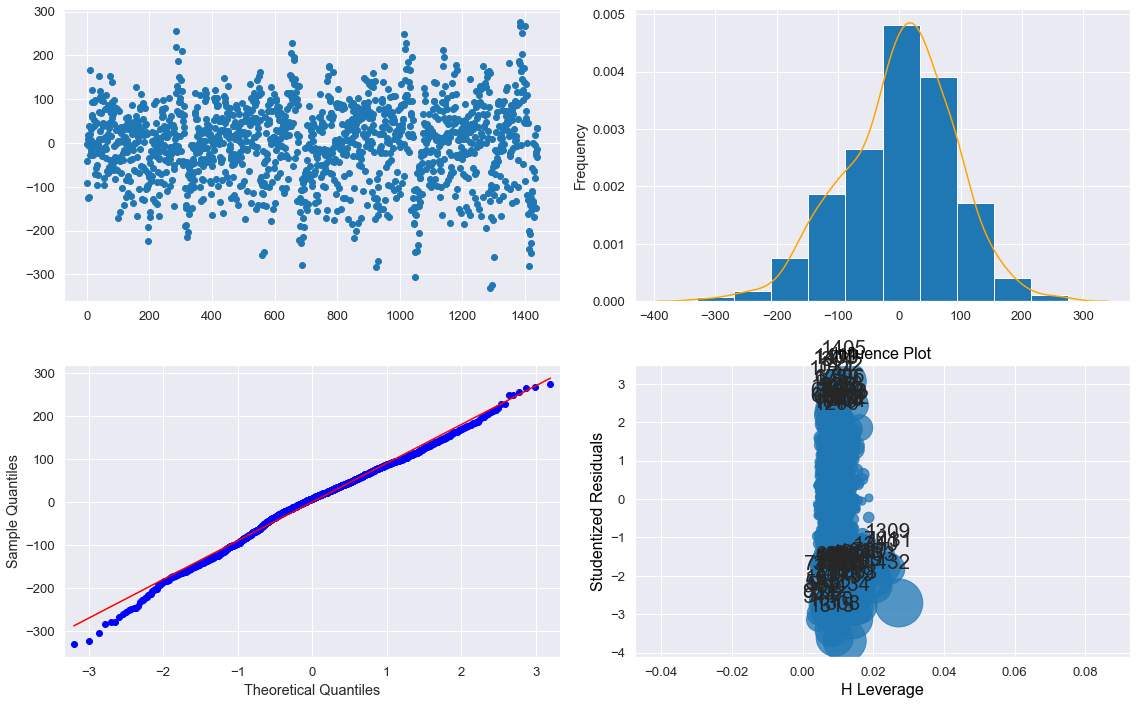

In [64]:
# Investigatng residuals
fig, ax = plt.subplots(2,2, figsize=(16, 10))
ax[0, 0].scatter(np.arange(len(LR.resid)), LR.resid)
LR.resid.plot(kind='hist', ax=ax[0, 1], density=True)
sns.kdeplot(LR.resid, color='orange', ax=ax[0, 1])
qqplot(LR.resid.sort_values(), line='s', ax=ax[1, 0])
sm.graphics.influence_plot(LR, criterion="cooks", ax=ax[1,1])
plt.tight_layout(pad=1.0)
plt.show()

Residuals look well behaved.<br>
Lets see how good is the forecast from the linear model.

In [65]:
# Get forecast and prediction intervals
xtest_LR = xtest.drop(columns=['ema_20', 'ema_50', 'ema_100', 'ema_200', 'ema_300', 'ma_243'])
ypred = LR.predict(xtest_LR)
pi = LR.get_prediction(xtest_LR).conf_int(alpha=0.05)
print('Accuracy of point forecasts from linear model: ', )
print('Mean absolute percentage error: ', mean_absolute_percentage_error(ytest, ypred))

Accuracy of point forecasts from linear model: 
Mean absolute percentage error:  0.08761725653576484


The forecasts are on average 8.7% off from the actual values.<br>
Lets plot the forecasts and intervals vs the actual values.

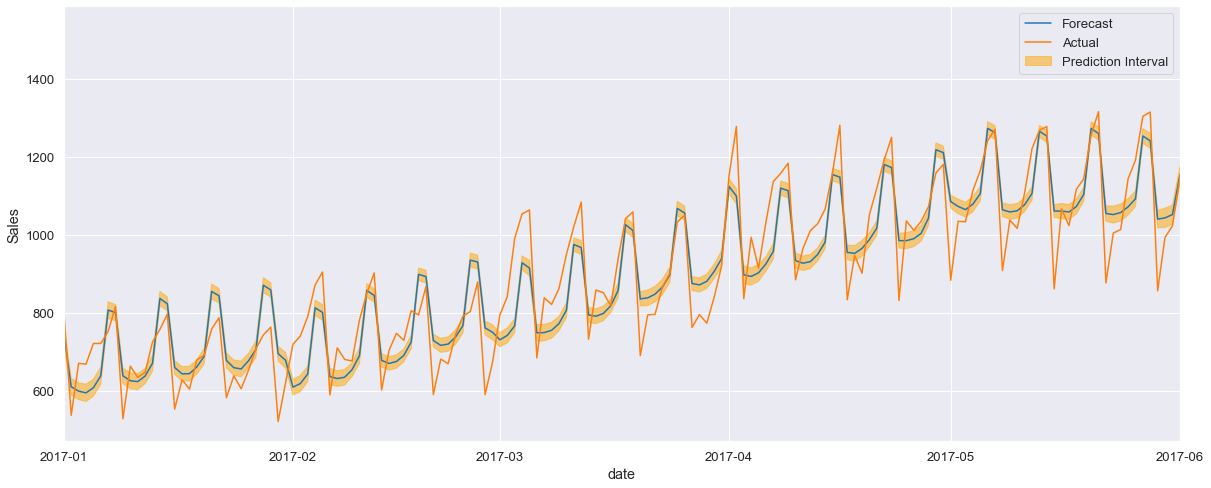

In [66]:
# Prediction plot
plot_x = sales15[sales15['date']>='2017']['date']
plt.figure(figsize=(20, 8))
plt.plot(plot_x, ypred, label='Forecast')
plt.fill_between(plot_x, pi[:, 1], pi[:, 0], color='orange', alpha=0.5, label='Prediction Interval')
plt.plot(plot_x, ytest, label='Actual' )
plt.xlim('2017-01', '2017-06')
plt.xlabel('date')
plt.ylabel('Sales')
plt.legend()


Feature Importance:

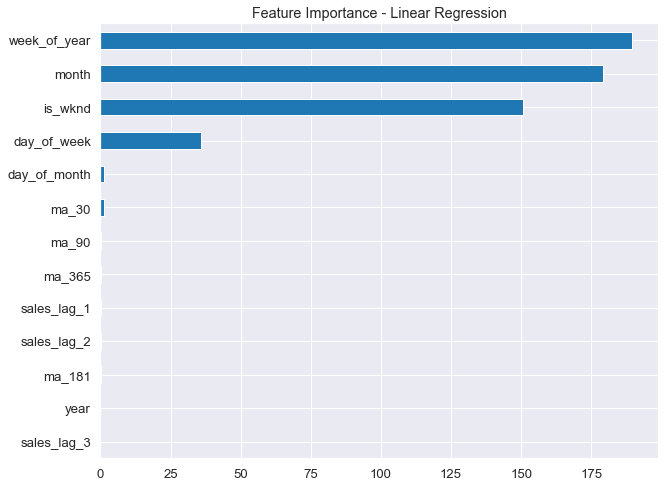

In [67]:
# Faeture Importance
plt.figure(figsize=(10, 8))
LR.params.abs().sort_values().plot(kind='barh')
_ = plt.title('Feature Importance - Linear Regression')

Looking at the plot of the forecasts, the linear model doesnt seem to capture the period fluctuations in sales to well.<br>
The feature importance plot shows that the model relies heavily on date time features rather that moving averages or lagged predictors.

### LightGBM Model

Next we use a lightGBM model to forecast sales for item no. 15.<br> Gradient boosting shows great performance for a wide variety of problems.

We will only be looking at point forecasts and no prediction intervals will be evaluated in this case.

In [68]:
import lightgbm as lgb

In [69]:
# Preparing dataset for lgb
cols = list(xtrain.columns)
train_lgb = lgb.Dataset(xtrain, label = ytrain, feature_name=cols)
val_lgb = lgb.Dataset(xtest, label=ytest, reference=train_lgb, feature_name=cols)

In [70]:
# Parameters for the gradient boost model
lgb_params = {'objective':'regression',
              'metric': {'mape'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'bagging_fraction': 0.8,
              'bagging_freq': 20,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_iterations': 15000,
              'early_stopping_rounds': 500,
              'nthread': -1}

lgb_model = lgb.train(lgb_params, train_lgb, num_boost_round=lgb_params['num_iterations'], 
                      valid_sets=[train_lgb, val_lgb], valid_names=['train_lgb', 'val_lgb'],
                      early_stopping_rounds=lgb_params['early_stopping_rounds'], verbose_eval=200)

Training until validation scores don't improve for 500 rounds
[200]	train_lgb's mape: 0.0384712	val_lgb's mape: 0.039687
[400]	train_lgb's mape: 0.0315195	val_lgb's mape: 0.0371395
[600]	train_lgb's mape: 0.0286491	val_lgb's mape: 0.0365714
[800]	train_lgb's mape: 0.0267721	val_lgb's mape: 0.0365258
[1000]	train_lgb's mape: 0.0251532	val_lgb's mape: 0.0366217
[1200]	train_lgb's mape: 0.0237923	val_lgb's mape: 0.0365606
[1400]	train_lgb's mape: 0.0224737	val_lgb's mape: 0.0369563
[1600]	train_lgb's mape: 0.0212198	val_lgb's mape: 0.0369059
Early stopping, best iteration is:
[1280]	train_lgb's mape: 0.0231908	val_lgb's mape: 0.0361398


We take a look at the feature importance for the LightGBM model. It is evaluated on the basis of the total gain acheived while splitting using a particular feature.

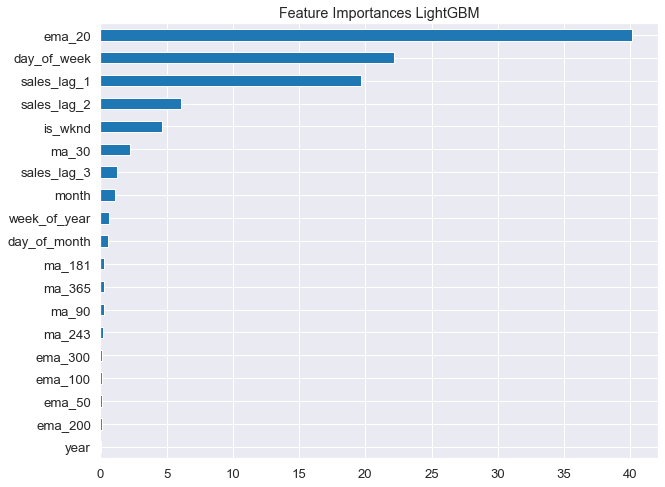

In [71]:
gain = lgb_model.feature_importance('gain')
split = lgb_model.feature_importance('split')
feat_imp = pd.DataFrame({'feature': lgb_model.feature_name(),
                        'split %': 100*split/split.sum(),
                        'gain %': 100 *gain/gain.sum()}).sort_values('gain %', ascending=False)

plt.figure(figsize=(10, 8))
feat_imp['gain %'].plot(kind='barh')
plt.yticks(ticks=np.arange(len(feat_imp)), labels=feat_imp['feature'])
plt.gca().invert_yaxis()
_ = plt.title('Feature Importances LightGBM')

Looks like the gradient boosting model picked up on the moving averages, lagged predictors as well as the date features.

Lets take a look at the model performance

In [72]:
# Getting forecasts
ypred_lgb = lgb_model.predict(xtest)
print('Accuracy of point forecasts from linear model: ', mean_absolute_percentage_error(ytest, ypred_lgb))

Accuracy of point forecasts from linear model:  0.036139785717185534


The gradient boost model performs much better with the forecasts being on an average 3.5% off.

Lets plot the forecasts and see how they look

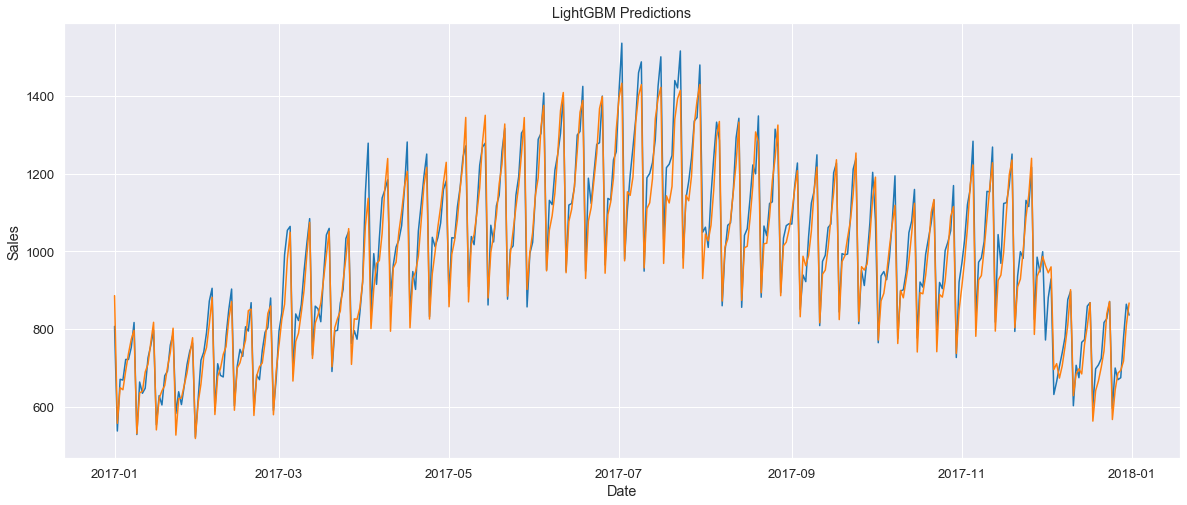

In [73]:
# Plotting forecasts from LightGBM model
plt.figure(figsize=(20, 8))
plt.plot(plot_x, ytest)
plt.plot(plot_x, ypred_lgb)
plt.title('LightGBM Predictions')
plt.ylabel('Sales')
_ = plt.xlabel('Date')

With this we come to an end of exploring time series forecasting methods and models.<br>
As a recap to this notebook:
 - We explored a time series dataset for forecasting sales
 - Set forecast expectations with benchmark methods of point forecasts, 
 - Explored the Holt-Winters' forecasting method and 
 - Deep dived into the two most popular time series models - 
     - ETS models
     - ARIMA models
 - Converted a time series problem into a supervised learning problem and applied regression models to predict sales.